Hidden State Activations (neuron activations) and Attention Weights (neural pathways) Heatmap visualizer V. 1.0.0

In [1]:
pip install transformers torch seaborn matplotlib numpy

Visualizing Neuron Activations and Pathways in MiniLM


In [2]:
import torch
from transformers import AutoTokenizer, AutoModel
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Load the model and tokenizer
model_name = "sentence-transformers/all-MiniLM-L6-v2"

# We use AutoModel instead of SentenceTransformer to get raw access to internal layers
tokenizer = AutoTokenizer.from_pretrained(model_name)
# output_hidden_states and output_attentions MUST be True to capture the internal workings
model = AutoModel.from_pretrained(
    model_name,
    output_hidden_states=True,
    output_attentions=True
)

model.eval() # Set to evaluation mode
print(f"Loaded {model_name} successfully.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loaded sentence-transformers/all-MiniLM-L6-v2 successfully.


Defining the Query and Running Inference
Let's propose a query regarding AI. We will tokenize it, run it through the model, and extract the embeddings, hidden states, and attention weights.


In [3]:
# 2. Propose a query
query = "How do artificial neural networks learn meta patterns?"

# 3. Tokenize the query
inputs = tokenizer(query, return_tensors="pt")

# Convert token IDs back to human-readable text for our heatmap labels
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
print(f"Tokens: {tokens}")

# 4. Run Inference
with torch.no_grad():
    outputs = model(**inputs)

# Extract the final sentence embedding (Mean Pooling)
# (This is what sentence-transformers outputs by default)
token_embeddings = outputs.last_hidden_state
attention_mask = inputs['attention_mask']
input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
sentence_embedding = torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

print(f"Sentence Embedding Shape: {sentence_embedding.shape}")

Tokens: ['[CLS]', 'how', 'do', 'artificial', 'neural', 'networks', 'learn', 'meta', 'patterns', '?', '[SEP]']
Sentence Embedding Shape: torch.Size([1, 384])


Heatmap 1: Neuron Activations (Hidden States)

The all-MiniLM-L6-v2 model has 6 Transformer layers. As a word passes through these layers, its embedding vector changes.

To visualize "activation levels," we will calculate the L2 Norm (magnitude) of the 384-dimensional hidden vector for each token at every layer. Brighter colors mean the neurons for that token are firing with higher magnitude at that specific depth.


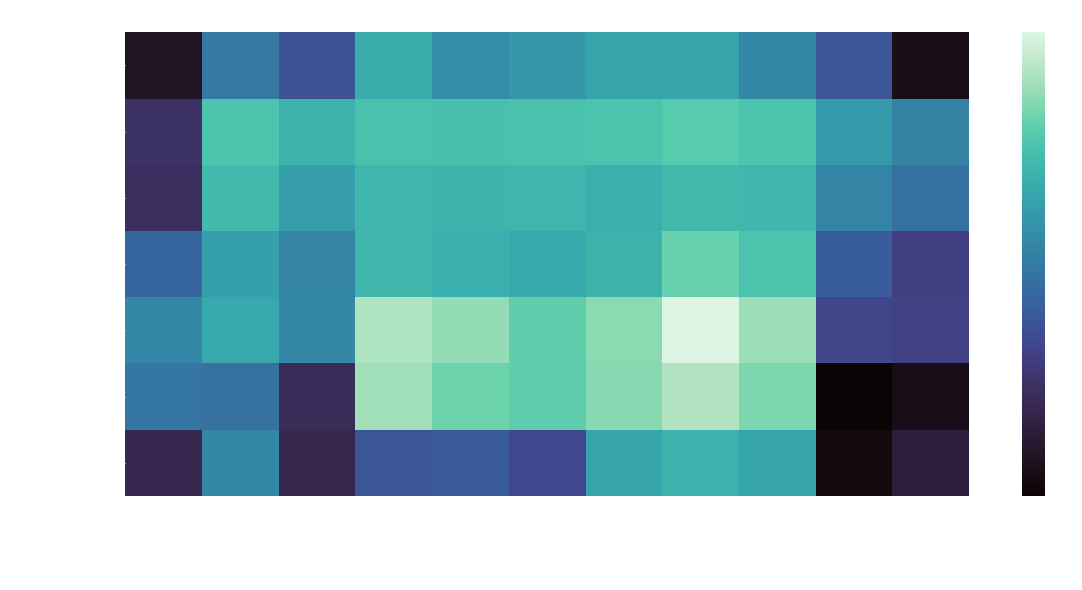

In [8]:
# Extract hidden states: Tuple of 7 tensors (Embedding output + 6 layers)
# Shape of each tensor: [batch_size, sequence_length, hidden_size(384)]
hidden_states = outputs.hidden_states

# Calculate the magnitude (L2 norm) of neuron activations for each token at each layer
activation_matrix = []
for layer_output in hidden_states:
    # Get the sequence output for this batch (batch index 0)
    seq_output = layer_output[0]
    # Calculate magnitude across the hidden dimension (dim=1)
    magnitudes = torch.norm(seq_output, p=2, dim=1).numpy()
    activation_matrix.append(magnitudes)

activation_matrix = np.array(activation_matrix)

# Y-axis labels for the layers
layer_labels = ["Embeddings"] + [f"Layer {i}" for i in range(1, 7)]

# Use rc_context to force all text, ticks, and labels to be white
with plt.rc_context({"text.color": "white", "axes.labelcolor": "white", "xtick.color": "white", "ytick.color": "white"}):
    # Set figure facecolor to 'none' for absolute transparency
    fig = plt.figure(figsize=(12, 6), facecolor='none')

    ax = sns.heatmap(
        activation_matrix,
        xticklabels=tokens,
        yticklabels=layer_labels,
        cmap="mako",
        linewidths=0.5,
        linecolor=(0, 0, 0, 0), # (R, G, B, Alpha=0) makes the dividing lines completely transparent
        annot=False
    )

    # Force the axes background to be completely transparent
    ax.patch.set_alpha(0.0)

    # Ensure colorbar ticks and edges are white/transparent
    cbar = ax.collections[0].colorbar
    if cbar:
        cbar.ax.yaxis.set_tick_params(color="white")
        cbar.outline.set_edgecolor("none")

    plt.title("Neuron Activation Magnitude Across Layers")
    plt.xlabel("Tokens")
    plt.ylabel("Model Depth")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Save with both transparent=True and facecolor="none"
    plt.savefig("activation_plot.png", format="png", transparent=True, facecolor="none", edgecolor="none", bbox_inches="tight")
    plt.show()

Heatmap 2: Mapping Neural Pathways (Attention Weights)


To see the "pathways" the model uses to understand the sentence, we look at the Self-Attention mechanism. This shows us which words the model is "looking at" when processing a specific word.
We will look at the last layer (Layer 6) and average the attention weights across all attention heads to see the final pathways the model formed before outputting the embedding.

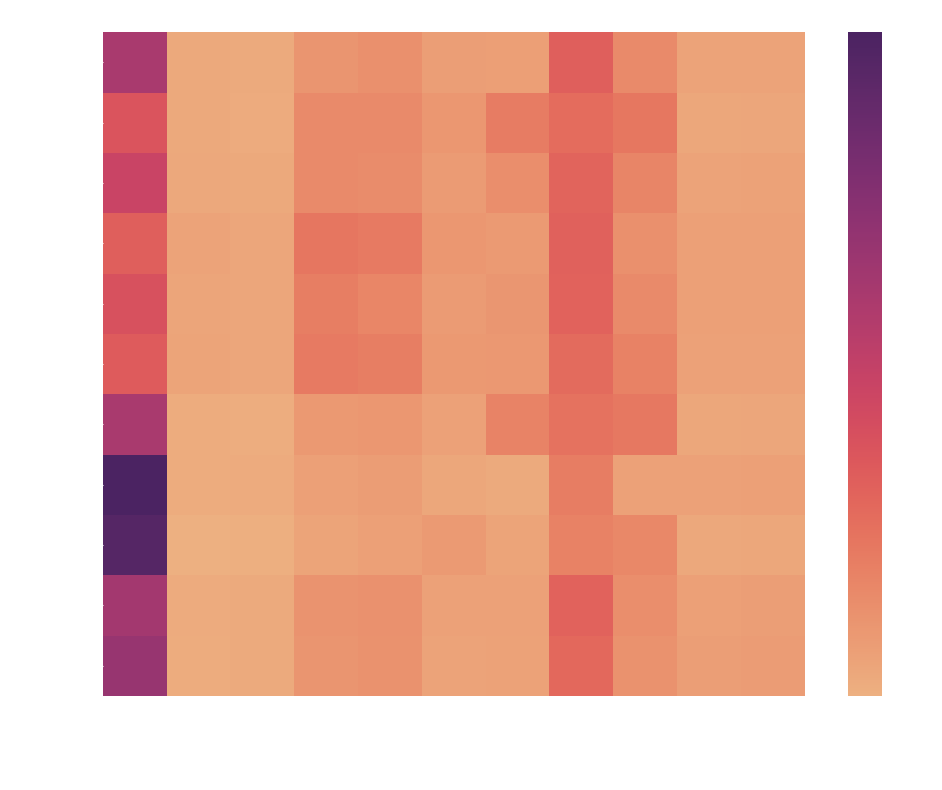

In [9]:
# Extract attentions: Tuple of 6 tensors (one for each layer)
# Shape of each tensor: [batch_size, num_heads, seq_len, seq_len]
attentions = outputs.attentions

# Select the last layer (index 5 for layer 6)
last_layer_attention = attentions[-1][0] # Get batch 0

# Average the attention weights across all 12 attention heads
# Shape becomes: [seq_len, seq_len]
avg_attention_pathways = torch.mean(last_layer_attention, dim=0).numpy()

# Use rc_context to force all text, ticks, and labels to be white
with plt.rc_context({"text.color": "white", "axes.labelcolor": "white", "xtick.color": "white", "ytick.color": "white"}):
    # Set figure facecolor to 'none' for absolute transparency
    fig = plt.figure(figsize=(10, 8), facecolor='none')

    ax = sns.heatmap(
        avg_attention_pathways,
        xticklabels=tokens,
        yticklabels=tokens,
        cmap="flare",
        linewidths=0.5,
        linecolor=(0, 0, 0, 0), # Transparent dividing lines
        annot=False,
        cbar_kws={'label': 'Attention Weight (Pathway Strength)'}
    )

    # Force the axes background to be completely transparent
    ax.patch.set_alpha(0.0)

    # Ensure colorbar ticks and edges are white/transparent
    cbar = ax.collections[0].colorbar
    if cbar:
        cbar.ax.yaxis.set_tick_params(color="white")
        cbar.outline.set_edgecolor("none")

    plt.title("Neural Pathways: Self-Attention in the Final Layer")
    plt.xlabel("Key Tokens (Information coming from)")
    plt.ylabel("Query Tokens (Information going to)")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()

    # Save with both transparent=True and facecolor="none"
    plt.savefig("attention_pathways.png", format="png", transparent=True, facecolor="none", edgecolor="none", bbox_inches="tight")
    plt.show()


How to Interpret the Results:
Neuron Activation Plot (mako / blue-green):

You will notice that the [CLS] token usually aggregates a massive amount of activation energy in the deeper layers. Punctuation (?) and [SEP] tokens also tend to show distinct activation patterns. The model uses these special tokens as holding spaces for sentence-level context.

Neural Pathways Plot (flare / orange-purple):

Look at the rows. If you look at the row for the word patterns, the brightest columns in that row show which other words the model used to give patterns its context (likely learn and networks). You will also see heavy vertical lines on [CLS] and [SEP], as the model routes global information through these hubs.

---

The previous attention heatmap showed how the model routed information (the mechanism). This visualization shows the result of that routing.
In a Transformer, as words pass through the layers, they exchange information. By the final layer, words that belong to the same concept (like "neural" and "networks") have absorbed so much context from each other that their 384-dimensional mathematical vectors actually align and point in similar directions in the latent space. We will calculate the Cosine Similarity between every token's final embedding to see how the model has grouped concepts together.

Heatmap 3: Contextualized Token Similarity


In standard word embeddings (like Word2Vec), words are isolated. In Transformers, words are contextualized. By the time the tokens reach the final layer, words that form a unified concept will have highly similar vectors.
Here, we extract the 384-dimensional vector for each word from the final layer, calculate the Cosine Similarity between every single pair of words, and plot it. This reveals the "semantic clustering" the model performed to understand the sentence.

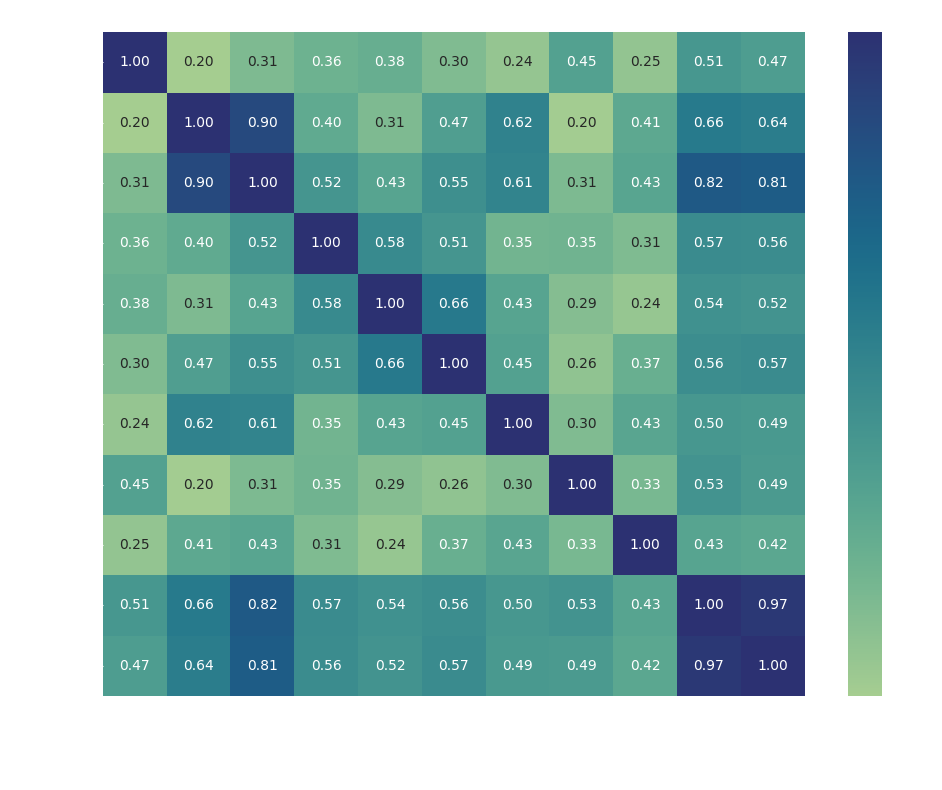

In [10]:
import torch.nn.functional as F

# 1. Get the final contextualized token embeddings from the last layer
# Shape: [sequence_length, 384]
final_token_embeddings = outputs.last_hidden_state[0]

# 2. Calculate Cosine Similarity
# First, we L2-normalize the 384-dimensional vectors
normalized_embeddings = F.normalize(final_token_embeddings, p=2, dim=1)

# Then, matrix multiplication of the normalized vectors gives the cosine similarity matrix
# Shape: [sequence_length, sequence_length]
similarity_matrix = torch.matmul(normalized_embeddings, normalized_embeddings.T).numpy()

# Use rc_context to force all text, ticks, and labels to be white
with plt.rc_context({"text.color": "white", "axes.labelcolor": "white", "xtick.color": "white", "ytick.color": "white"}):
    # Set figure facecolor to 'none' for absolute transparency
    fig = plt.figure(figsize=(10, 8), facecolor='none')

    ax = sns.heatmap(
        similarity_matrix,
        xticklabels=tokens,
        yticklabels=tokens,
        cmap="crest", # A green/blue colormap to distinguish from previous plots
        linewidths=0.5,
        linecolor=(0, 0, 0, 0), # Transparent dividing lines
        annot=True,   # Turning on annotations to see the exact similarity scores
        fmt=".2f",    # Round to 2 decimal places
        cbar_kws={'label': 'Cosine Similarity'}
    )

    # Force the axes background to be completely transparent
    ax.patch.set_alpha(0.0)

    # Ensure colorbar ticks and edges are white/transparent
    cbar = ax.collections[0].colorbar
    if cbar:
        cbar.ax.yaxis.set_tick_params(color="white")
        cbar.outline.set_edgecolor("none")

    plt.title("Semantic Clustering: Contextualized Token Similarity (Final Layer)")
    plt.xlabel("Tokens")
    plt.ylabel("Tokens")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()

    # Save with both transparent=True and facecolor="none"
    plt.savefig("semantic_clustering.png", format="png", transparent=True, facecolor="none", edgecolor="none", bbox_inches="tight")
    plt.show()

How to Interpret the Bonus Results:

The Diagonal is 1.00: Every word is 100% perfectly similar to itself, hence the dark diagonal line.

Noun Phrase Clustering: Look at the intersection between neural and networks. You will likely see a very high cosine similarity score (e.g., > 0.70). Even though they entered the model as entirely different words, the Transformer has fused their meanings into a single "neural network" concept in the embedding space.

The [CLS] Token's Job: Look at the [CLS] row/column. Sentence-transformers are trained to make the [CLS] token represent the entire sentence. You will see that [CLS] has a relatively high similarity to the most important semantic words in the query (like learn, patterns, or networks), and very low similarity to filler words (like how, do).

Ronni Ross  
2026